In [1]:
%matplotlib inline
#standard imports 
import numpy as np
import matplotlib.pyplot as plt
import random
import math

We consider an experiment of tossing a coin n times and counting number of heads. The coin can be unfair, which means that the probability of head is not 0.5.

- n - number of coins
- k - number of heads
- p - probability of head in a single toss




We will use Maximum Likelihood Estimate (MLE) and Maximum A Posteriori Estimate (MAP) to estimate the frequency of 
heads, to decide if the coin is fair.

The probability mass function of the process is given by the Binomial distrbution

# pmf(k|n,p) = n!/(k! * (n-k)!)  p^k (1-p)^(n-k)

k  is a random variable. p,n are parameters.

In [2]:
#Not efficient but who cares ;-)
def combCoef(n,k):
    a = math.factorial(n)
    b = math.factorial(k)
    c = math.factorial(n-k)
    return a/(b*c)



def binomial_pmf(n,k,p):
    return combCoef(n,k) * p**k * (1-p)**(n-k)
    

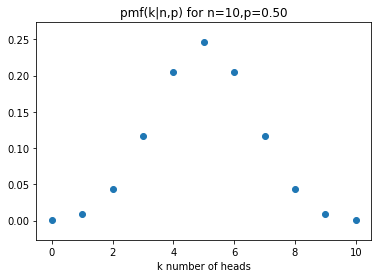

In [3]:
def total_binomial_pmf(n,p):
    ks = [k for k in range(n+1)]
    return (ks, [binomial_pmf(n,k,p) for k in ks])
n = 10
p = 0.5
ks, values = total_binomial_pmf(n,p)
plt.title('pmf(k|n,p) for' + format(' n=%d,p=%.2f'%(n,p)))
plt.xlabel('k number of heads')
plt.scatter(ks, values)

In [4]:
print ('pmf normalization = ' +format('%f'%float(sum(values))))

pmf normalization = 1.000000


In [5]:
def total_binomial_likelihood(n,k):
    ps= list(np.arange(0,1.,0.05))
    return (ps, [binomial_pmf(n,k,p) for p in ps])

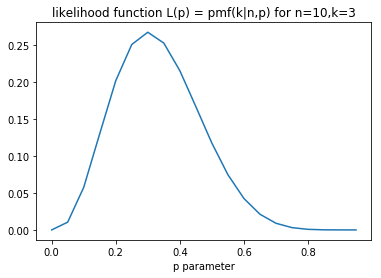

In [6]:
n = 10
k = 3
ps,values2 = total_binomial_likelihood(n,k)
plt.title('likelihood function L(p) = pmf(k|n,p) for' + format(' n=%d,k=%d'%(n,k)))
plt.xlabel('p parameter')
plt.plot(ps,values2)

In [7]:
print ('likelihood normalization can be different than one 1 = ' +format('%f'%float(sum(values2)*0.05)))

likelihood normalization can be different than one 1 = 0.090915


As expected, If we observe in series of n=10 tosses k=3 heads, then the maximum value of the likelihood function

# L(p) =  pmf(k=3|n =10,p) 

# p_MLE = argmax L(p)   = 0.3

Alternatively we can say that among several pmfs for different p values (each pmf is a diffrent model models) we see that the maximum values for k=3 is given by the model with p = 0.3.

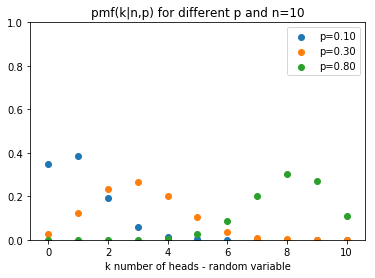

In [8]:
ps = [0.1,0.3,0.8]
n = 10
for p in ps:
    ks,vals = total_binomial_pmf(n,p)
    plt.scatter(ks,vals, label=format('p=%.2f'%p))
plt.ylim(0,1)
plt.xlabel('k number of heads - random variable')
plt.title('pmf(k|n,p) for different p and'+ format(' n=%d'%n))
plt.legend()
plt.show()

If we calculate the estimate analytically we get:
# p_MLE = k/n

We can also check what is the convergence behaviour with number of samples

In [9]:
def tossCoins(num,p):
    return np.random.choice(['H','T'],p=[p,1-p], size=num)
def getHeads(li):
    return float(len([x for x in li if x=='H']))
def getSeries(p, samples):
    return [getHeads(tossCoins(s,p))/float(s) for s in samples]


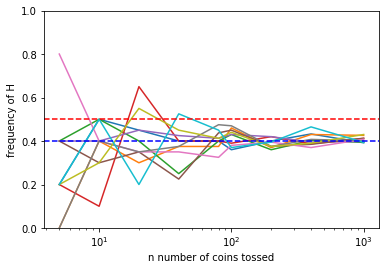

In [10]:
samples = [5,10,20,40,80,100,200,400, 1000]
nSamples =10
p=0.4  # true p value.

results=[getSeries(p, samples) for _ in range(nSamples)]
for r in results:
    plt.plot(samples, r)
plt.xscale('log')
plt.ylim(0.0,1)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axhline(y=0.4, color='blue', linestyle='--')
plt.ylabel('frequency of H')
plt.xlabel('n number of coins tossed')
plt.show()

We can see that for small n the estimate can be quite different from true 0.4.
This is because e.g. the sequence of T,T,T,T is still probable and it would give estimate p_MLE = 0

Now, we move to MAP - we are going to incorporate our assumptions about the distribution of p parameters prior to any experiment. The prior distribution will be modeled by the beta function. 

## pdf(p |alpha, beta) =  (alpha-1)!* (beta-1)!/(alpha+beta -1)!  * p^(alpha-1) * (1-p)^(beta-1)

p here is the random variable, while alpha and beta are hyperparameters.

In [11]:
def beta_func(p,q):
    a = math.factorial(p - 1)
    b = math.factorial(q - 1)
    c = math.factorial(p + q -1)
    return a*b/c

def beta_pdf(p,alpha,beta):
    norm = beta_func(alpha,beta)
    return  p**(alpha-1) * (1-p)**(beta-1)/norm

In [12]:
def total_beta_pdf(alpha,beta):
    ps= list(np.arange(0,1.01,0.05))
    return (ps, [beta_pdf(p,alpha,beta) for p in ps])

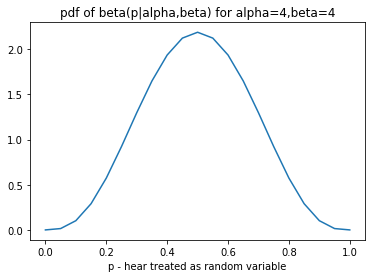

In [13]:
alpha = 4
beta = 4
ps,values2 = total_beta_pdf(alpha,beta)
plt.title('pdf of beta(p|alpha,beta) for' + format(' alpha=%d,beta=%d'%(alpha,beta)))
plt.xlabel('p - hear treated as random variable')
plt.plot(ps,values2)

In [14]:
print ('pdf normalization of p = ' +format('%.2f'%float(sum(values2)* 0.05)))

pdf normalization of p = 1.00


The nice feature of beta function is that it is conjugate distribution to the binomial distribution.

Bayes theorem gives :
## posterior distribution ~ observation  * prior distribution

which is:

## pdf(p|alpha +k, beta+ (n-k)) ~ pmf(k|n, p) * pdf(p|alpha, beta) 

This gives us a possibility to update our prior distribution with every measurement.
The posterior distribution becomes our prior for the next observation.

MAP estimation consists of finding the p_MAP that would maximize the pdf, so the p values
for which the posteriod distribution gives the maximum probability. The maximum is given by mode of the function.

## p_MLE = argmax pdf(p)   = mode(beta_pdf(alpha + k,beta + n-k)) 
## = (alpha+k-1)/(alpha + k + beta + n-k -2) 

## p_MLE  = (alpha+k-1)/(alpha + beta +n-2)

In [15]:
def mode_of_beta(p,q):
    return (p - 1.)/(p+q -2.)

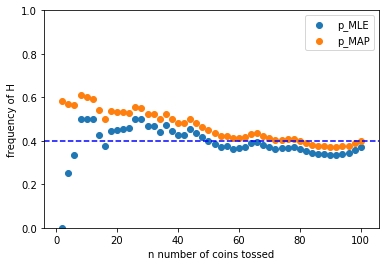

In [29]:
# compare MLE with MAP, starting with prior beta(4,4). and assuming true p =0.4
true_p = 0.4
n = 2
alpha = 8.
beta = 4.

alpha_tot=[alpha]
beta_tot=[beta]
n_tot = [0]
heads_tot = [0]
p_MLE=[]
p_MAP=[]

for _ in range(50):
    #print('****')
    coins = tossCoins(n,true_p)
    heads = getHeads(coins)
    n_tot.append(n_tot[-1] + n)
    heads_tot.append(heads_tot[-1]+heads)
    curr_alpha = alpha_tot[-1]
    curr_beta = beta_tot[-1]
    alpha_tot.append(alpha_tot[-1]+heads)
    beta_tot.append(beta_tot[-1]+(n-heads))
    p_MLE.append(float(heads_tot[-1])/float(n_tot[-1]))
    p_MAP.append(float(alpha_tot[-1] - 1)/float(alpha_tot[-1]+ beta_tot[-1] -2))
    #print(coins)
    #print(float(heads_tot[-1]))
    #print(float(n_tot[-1]))
    #print('p_MLE='+format('%f'%(float(heads_tot[-1])/float(n_tot[-1]))))
    #print('p_MAP='+format('%f'%(float(alpha_tot[-1])/float(alpha_tot[-1]+ beta_tot[-1]))))
    #print('p_MAP_mode='+format('%f'%(float(alpha_tot[-1] -1)/float(alpha_tot[-1]+ beta_tot[-1] -2))))

plt.scatter(n_tot[1:],p_MLE, label='p_MLE')
plt.scatter(n_tot[1:],p_MAP, label='p_MAP')
plt.ylim(0,1)
plt.axhline(y= true_p, color='blue', linestyle='--')
plt.ylabel('frequency of H')
plt.xlabel('n number of coins tossed')
plt.legend()
plt.show()

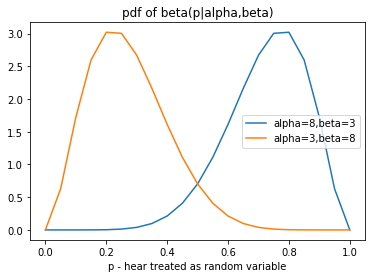

In [17]:
# Show that for two very different priors with enough large data it tends to be the same 
alpha_1 = 8.
beta_1 = 3.
alpha_2 = 3.
beta_2 = 8.
ps,values = total_beta_pdf(alpha_1,beta_1)
ps2,values2 = total_beta_pdf(alpha_2,beta_2)
plt.title('pdf of beta(p|alpha,beta)')
plt.xlabel('p - hear treated as random variable')
plt.plot(ps,values, label = 'alpha=8,beta=3')
plt.plot(ps,values2, label = 'alpha=3,beta=8')
plt.legend()
plt.show()

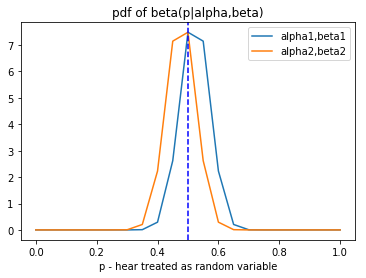

In [18]:
n = 100
true_p = 0.5
alpha_1 = 8.
beta_1 = 3.
alpha_2 = 3.
beta_2 = 8.
coins = tossCoins(n,true_p)
k = getHeads(coins)
ps,values = total_beta_pdf(alpha_1 + k,beta_1 + (n -k))
ps2,values2 = total_beta_pdf(alpha_2 + k,beta_2 + (n-k))
plt.title('pdf of beta(p|alpha,beta)')
plt.xlabel('p - hear treated as random variable')
plt.plot(ps,values, label = 'alpha1,beta1')
plt.plot(ps,values2, label = 'alpha2,beta2')
plt.axvline(x= true_p, color='blue', linestyle='--')

plt.legend()
plt.show()

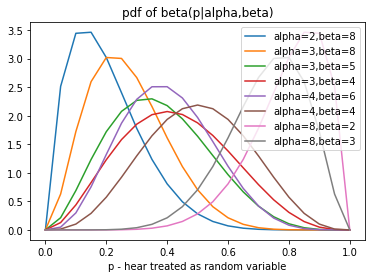

In [19]:
#show several different alpha and beta parameters


plt.title('pdf of beta(p|alpha,beta)')
plt.xlabel('p - hear treated as random variable')
ps,values = total_beta_pdf(2,8)
plt.plot(ps,values, label = 'alpha=2,beta=8')
ps,values = total_beta_pdf(3,8)
plt.plot(ps,values, label = 'alpha=3,beta=8')
ps,values = total_beta_pdf(3,5)
plt.plot(ps,values, label = 'alpha=3,beta=5')
ps,values = total_beta_pdf(3,4)
plt.plot(ps,values, label = 'alpha=3,beta=4')
ps,values = total_beta_pdf(4,6)
plt.plot(ps,values, label = 'alpha=4,beta=6')
ps,values = total_beta_pdf(4,4)
plt.plot(ps,values, label = 'alpha=4,beta=4')
ps,values = total_beta_pdf(8,2)
plt.plot(ps,values, label = 'alpha=8,beta=2')
ps,values = total_beta_pdf(8,3)
plt.plot(ps,values, label = 'alpha=8,beta=3')
ps,values = total_beta_pdf(5,3)

plt.legend()
plt.show()

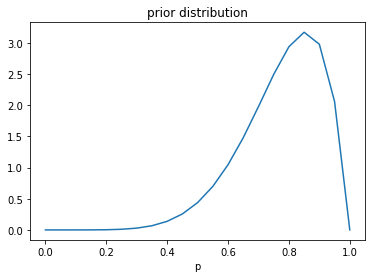

['T' 'T' 'T']


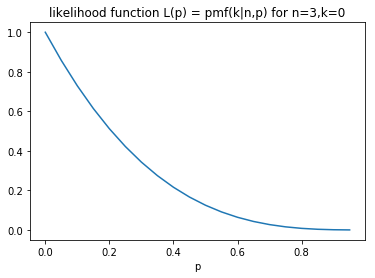

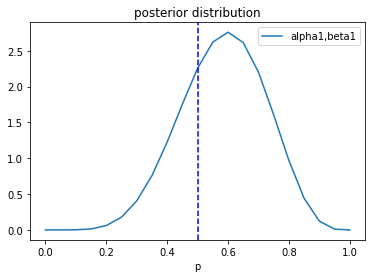

['H' 'T' 'H']


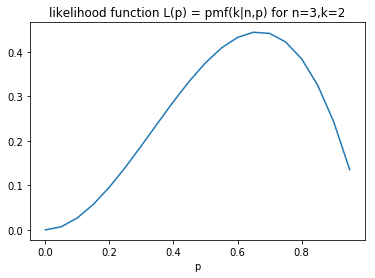

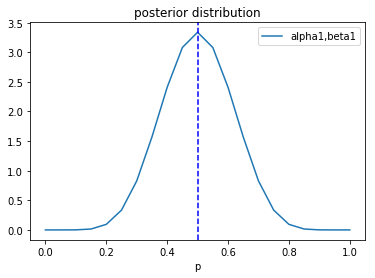

['T' 'T' 'H']


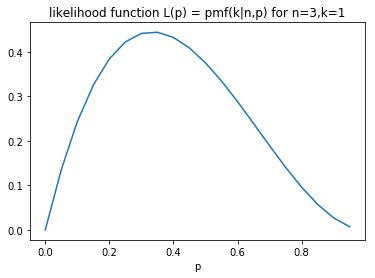

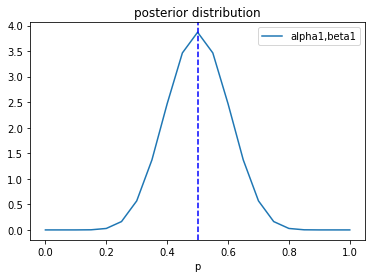

['T' 'T' 'H']


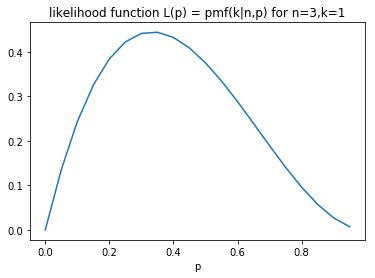

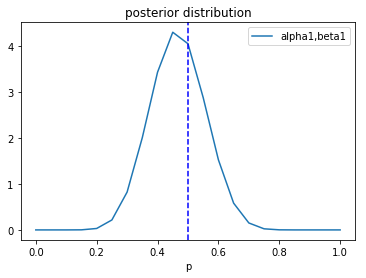

['H' 'H' 'H']


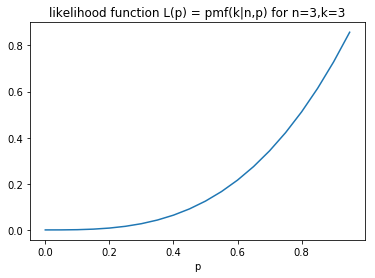

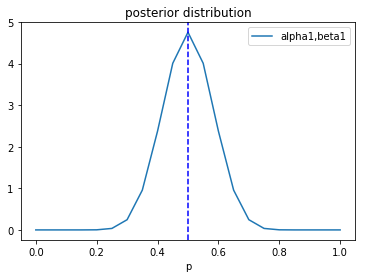

In [20]:
# Show step by step for 2 cases
n = 3
true_p = 0.5
alpha = 7.
beta = 2.
ps,prior_values = total_beta_pdf(alpha,beta)
plt.title('prior distribution')
plt.xlabel('p')
plt.plot(ps,prior_values, label = 'alpha,beta')
plt.show()

for _ in range(5):
    coins = tossCoins(n,true_p)
    k = getHeads(coins)
    print (coins)

    ps,observation_values = total_binomial_likelihood(n,k)
    plt.title('likelihood function L(p) = pmf(k|n,p) for' + format(' n=%d,k=%d'%(n,k)))
    plt.xlabel('p')
    plt.plot(ps,observation_values)
    plt.show()

    alpha = alpha + k
    beta = beta + (n -k)
    ps,posterior_values = total_beta_pdf(alpha,beta)
    plt.title('posterior distribution')
    plt.xlabel('p')
    plt.plot(ps,posterior_values, label = 'alpha1,beta1')
    plt.axvline(x= true_p, color='blue', linestyle='--')
    plt.legend()
    plt.show()
    alpha = alpha + k
    beta = beta + (n -k)